In [42]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [43]:
import os
import pickle as pk
import numpy as np
from sklearn.decomposition import PCA, FastICA, FactorAnalysis

# from phys import data_utils, phys_utils
# from phys.plot_scripts import generic_plot_utils as rr_gpu
from utils import data_utils, phys_utils
from utils import generic_plot_utils as rr_gpu

In [44]:
def load_neural_data_base(subject_id, mask_fn, 
                          condition='occ', 
                          neural_data_to_use='neural_responses_reliable_FactorAnalysis_20'):
    neural_data = data_utils.load_neural_dataset(subject_id=subject_id, timebinsize=50, recompute_augment=False)

    condition = 'occ'
    beh_to_decode = ['ball_pos_x_TRUE', 'ball_pos_y_TRUE', 'ball_pos_dx_TRUE', 'ball_pos_dy_TRUE',
                    't_from_start', 't_from_occ', 't_from_end']

    mask_fn_neur = mask_fn_beh = mask_fn
    mask_neur_cxt = np.array(neural_data['masks'][condition][mask_fn_neur])
    mask_beh_cxt = np.array(neural_data['masks'][condition][mask_fn_beh])

    data_neur_nxcxt = np.array(neural_data[neural_data_to_use][condition])
    data_beh_bxcxt = np.array([neural_data['behavioral_responses'][condition][fk] for fk in beh_to_decode])

    data = {
        'data_neur_nxcxt': data_neur_nxcxt,
        'data_beh_bxcxt': data_beh_bxcxt,
        'mask_neur_cxt': mask_neur_cxt,
        'mask_beh_cxt': mask_beh_cxt,
    }
    return data

In [45]:
def convert_to_mat_pool_conditions_and_time_dims(x_nxcxt, y_bxcxt, mask_cxt):
    """ turn NxCxT into CT x N. remove CT dims that are NaN.
    This is done for mapping with matched time (each timepoint is another point in state space).
    flatten_to_mat turns the first two dimensions into 1 cxtxn -> cxt x n
    """
    x_cxtxn = np.transpose(x_nxcxt, (1, 2, 0))
    y_cxtxb = np.transpose(y_bxcxt, (1, 2, 0))

    # omit times and conditions where any feature or any label is NaN
#     mask_cxt = np.mean(x_nxcxt, axis=0) * np.mean(y_bxcxt, axis=0)
    mask_cxtx1 = np.expand_dims(mask_cxt, axis=2)

    res_x = phys_utils.flatten_to_mat(x_cxtxn, mask_cxtx1)
    res_y = phys_utils.flatten_to_mat(y_cxtxb, mask_cxtx1)
#     res_g = phys_utils.flatten_to_mat(cond_cxtx1, mask_cxtx1)

    mat_data = {
        'x': np.array(res_x['X']),
        'y': np.array(res_y['X']),
#         'g': np.array(res_g['X']),
#         'unflatten_res': res_g,
    }
    return mat_data



In [46]:
def flatten_and_mask(x_nxcxt, mask_cxtx1):
    x_cxtxn = np.transpose(x_nxcxt, (1,2,0))
    res_x = phys_utils.flatten_to_mat(x_cxtxn, mask_cxtx1)
    return np.array(res_x['X'])

def get_flattened_masked_data(subject_id, mask_fn):
    dset = data_utils.load_neural_dataset(subject_id=subject_id)
    mask = np.expand_dims(dset['masks']['occ'][mask_fn], axis=2)
    return flatten_and_mask(dset['neural_responses_reliable']['occ'], mask)

def get_pca_res_base(x_ctxn):
    pca = PCA(n_components=None, svd_solver='full')
    tmp = pca.fit_transform(x_ctxn)
    eigen_vals = pca.explained_variance_
    exp_var = pca.explained_variance_ratio_
    pr = np.nansum(eigen_vals) ** 2 / np.nansum(eigen_vals ** 2)
    return {'pr': pr, 'exp_var': exp_var, 'eigen_vals': eigen_vals}

def shuffle_data_matrix(x):
    x_shuf = x.flatten()
    np.random.shuffle(x_shuf)
    return np.reshape(x_shuf, x.shape )

def get_pca_res(x_ctxn, nshuf=2):
    res = {}
    res['true'] = get_pca_res_base(x_ctxn)
    res['shuf'] = []

    for i in range(nshuf):
        x_ctxn_shuf = shuffle_data_matrix(x_ctxn)
        res['shuf'].append(get_pca_res_base(x_ctxn_shuf))
    return res


# panel A: perle

In [47]:
data = load_neural_data_base('perle_hand_dmfc', 'start_end_pad0', neural_data_to_use='neural_responses_reliable')
x, y = data['data_neur_nxcxt'], data['data_beh_bxcxt']
mask_cxt = data['mask_neur_cxt']
mat_data = convert_to_mat_pool_conditions_and_time_dims(x, y, mask_cxt)


In [48]:
subject_id = 'perle_hand_dmfc' # 'perle_hand_dmfc' # mahler_hand_dmfc50
mask_fn = masks_to_test_suffix = 'start_end_pad0'
timebinsize = 50
neural_data_to_use = 'neural_responses_reliable_FactorAnalysis_50'
condition = 'occ'

In [49]:
x_ctxn_ = get_flattened_masked_data(subject_id, mask_fn)
res_all = get_pca_res(x_ctxn_)

res_, res_shuf_list = res_all['true'], res_all['shuf']
ndim_lehky = [np.nonzero(res_['exp_var'] <= res_shuf['exp_var'])[0][0] for res_shuf in res_shuf_list]

In [50]:
res_, res_shuf_list = res_all['true'], res_all['shuf']

In [51]:
np.savetxt('perle_scree.csv',res_['exp_var'], fmt='%5.3f', delimiter=',', newline='\n')
print(res_['exp_var'])
print(' '.join(map(str, res_['exp_var'])))

[3.55075687e-01 8.96843738e-02 3.50110691e-02 ... 6.93602383e-06
 6.34390099e-06 4.52690891e-06]
0.35507568719273314 0.08968437379764535 0.03501106913804878 0.030094059005855777 0.023717818343145798 0.019073573700093816 0.016591180232858126 0.015221462849154765 0.013058670238924477 0.012993507034518365 0.010286771269629328 0.009596197833624762 0.009293410690249304 0.008666206193492211 0.006869384387015749 0.006553780144283453 0.005659740760936025 0.00551624251623858 0.005395073408342391 0.004868963777688477 0.004404474879794909 0.004214976126817313 0.004099970788313555 0.0038361246332223532 0.003578159736212219 0.0035177071896089402 0.003260543234676394 0.0031646594224177945 0.003133688405345412 0.0030177539421685543 0.002823878067200814 0.0027629999477319822 0.002652357086482026 0.0026119518937198914 0.002571015652888167 0.002431599278075263 0.0023644976728970533 0.002305321582333386 0.0022567580383405683 0.0022309689904527045 0.0021084465363345054 0.002102247531658814 0.0020066658280

[1.86494614e-03 1.82819641e-03 1.81442064e-03 ... 7.29707740e-05
 7.17932951e-05 7.01079898e-05]
[1.83779105e-03 1.81528524e-03 1.80460111e-03 ... 7.35987335e-05
 7.32697181e-05 7.22075425e-05]


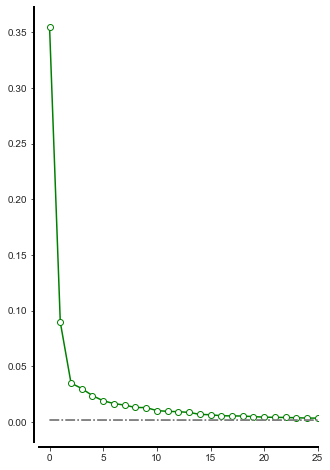

In [52]:
f,axes = plt.subplots(1,1,figsize=(5,8))
axes.plot(res_['exp_var'], '-o', mec='g', mfc='w', color='g')
for res_shuf in res_shuf_list:
    axes.plot(res_shuf['exp_var'], '-.', mec=[0.5, 0.5, 0.5], mfc='w', color=[0.5, 0.5, 0.5])
    print(res_shuf['exp_var'])
    np.savetxt('perle_shuffle_scree.csv',res_shuf['exp_var'], fmt='%5.3f', delimiter=',', newline='\n')
axes.set_xlim([-1,25])
rr_gpu.make_axis_nice(axes)


# panel B: mahler

In [53]:
data = load_neural_data_base('mahler_hand_dmfc', 'start_end_pad0', neural_data_to_use='neural_responses_reliable')
x, y = data['data_neur_nxcxt'], data['data_beh_bxcxt']
mask_cxt = data['mask_neur_cxt']
mat_data = convert_to_mat_pool_conditions_and_time_dims(x, y, mask_cxt)


In [54]:
subject_id = 'mahler_hand_dmfc' # 'perle_hand_dmfc' # mahler_hand_dmfc50
mask_fn = masks_to_test_suffix = 'start_end_pad0'
timebinsize = 50
neural_data_to_use = 'neural_responses_reliable_FactorAnalysis_50'
condition = 'occ'

In [55]:
x_ctxn_ = get_flattened_masked_data(subject_id, mask_fn)
res_all = get_pca_res(x_ctxn_)

res_, res_shuf_list = res_all['true'], res_all['shuf']
ndim_lehky = [np.nonzero(res_['exp_var'] <= res_shuf['exp_var'])[0][0] for res_shuf in res_shuf_list]

In [56]:
res_, res_shuf_list = res_all['true'], res_all['shuf']

In [57]:
np.savetxt('mahler_scree.csv',res_['exp_var'], fmt='%5.3f', delimiter=',', newline='\n')
print(res_['exp_var'])
print(' '.join(map(str, res_['exp_var'])))

[4.98736425e-01 2.40124921e-01 1.04953827e-01 8.25070391e-02
 7.29739521e-03 4.66183660e-03 4.62728978e-03 2.72606443e-03
 2.41414797e-03 2.32650209e-03 2.05764479e-03 1.84831196e-03
 1.49797839e-03 1.37441939e-03 1.22461729e-03 1.02542789e-03
 1.00661410e-03 9.60083014e-04 8.33439859e-04 7.12700080e-04
 6.97425166e-04 6.54057024e-04 6.47738621e-04 6.14469605e-04
 6.01025295e-04 5.61082507e-04 5.43888401e-04 5.16719023e-04
 4.94438256e-04 4.71087340e-04 4.52772180e-04 4.33503386e-04
 4.16425662e-04 3.99728617e-04 3.81831765e-04 3.71396482e-04
 3.66077849e-04 3.51490275e-04 3.41029842e-04 3.31529860e-04
 3.26953042e-04 3.20216409e-04 3.10190406e-04 2.97820163e-04
 2.96866387e-04 2.87147630e-04 2.70399010e-04 2.64943202e-04
 2.63184332e-04 2.60980740e-04 2.57993887e-04 2.52252259e-04
 2.46918362e-04 2.44918676e-04 2.43712961e-04 2.38304446e-04
 2.34914577e-04 2.29703021e-04 2.26237199e-04 2.25741274e-04
 2.22042187e-04 2.18097121e-04 2.16254856e-04 2.10999843e-04
 2.09786257e-04 2.076404

[0.0055032  0.00542018 0.00539728 0.00534614 0.00527322 0.00518621
 0.00516968 0.00514574 0.00510757 0.00506541 0.00504487 0.00503559
 0.00498734 0.00494189 0.00492594 0.00488669 0.0048727  0.00484259
 0.00482328 0.00479036 0.00476849 0.00474722 0.00473675 0.00471034
 0.00468393 0.0046527  0.00463158 0.00461449 0.00460933 0.00458461
 0.00453981 0.00452398 0.00450945 0.00449688 0.00448416 0.00447269
 0.00445714 0.00443759 0.00441381 0.00439181 0.0043863  0.00437306
 0.00433992 0.00432637 0.00429667 0.00427513 0.00425876 0.00424293
 0.00423301 0.00419652 0.00418923 0.00417332 0.00415957 0.0041481
 0.00414097 0.00412308 0.00410338 0.00408959 0.00407494 0.00405949
 0.00405714 0.0040414  0.00401276 0.0040043  0.00399578 0.00399023
 0.00397602 0.00394739 0.00394111 0.0039203  0.00391286 0.00389853
 0.00387853 0.00385933 0.0038511  0.00384645 0.00383613 0.00381811
 0.00381056 0.00379919 0.00379676 0.00377667 0.00375769 0.0037464
 0.00374124 0.00372084 0.00369747 0.00368519 0.00366591 0.003653

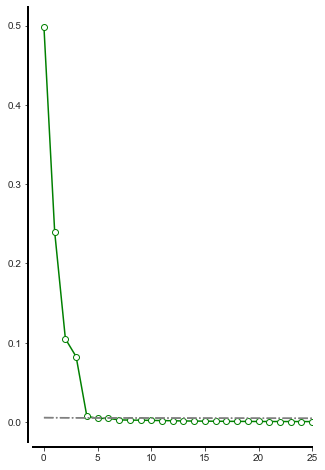

In [58]:
f,axes = plt.subplots(1,1,figsize=(5,8))
axes.plot(res_['exp_var'], '-o', mec='g', mfc='w', color='g')
for res_shuf in res_shuf_list:
    axes.plot(res_shuf['exp_var'], '-.', mec=[0.5, 0.5, 0.5], mfc='w', color=[0.5, 0.5, 0.5])
    print(res_shuf['exp_var'])
    np.savetxt('mahler_shuffle_scree.csv',res_shuf['exp_var'], fmt='%5.3f', delimiter=',', newline='\n')
axes.set_xlim([-1,25])
rr_gpu.make_axis_nice(axes)
